#### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy.stats import pearsonr,spearmanr,stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import datetime
from sklearn.metrics import mean_absolute_error

#### Installs

In [2]:
pip install keras

#### Dataloader

In [3]:
columns = ["TD[?]", "PROD[?]", "Measurement Point", "CP[?]", "Date", "Number of Measurements",
                    "00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00", "07:00",
                    "08:00", "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00",
                    "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00",
                    "Accumulated"]

hour_list = columns[6:30]

def oneDimentionalize(df):
    # new_df = (df.drop('Date', axis=1)
    #             .stack().reset_index())
#                .drop(["level_0", "level_1"], axis=1))
    # new_df.columns = ["Date", "Hour", "Consuption"]

    new_df = (df.melt(id_vars=['Date', 'ifWeekend'],
                     var_name='Hour',
                     value_name='Consumption')
              .sort_values(by=['Date', 'Hour'])
              .reset_index(drop=True))

    new_df['Date'] = new_df['Date'].dt.strftime("%Y-%m-%d")
    new_df['Time'] = new_df['Date'] + "T" + new_df['Hour']
    new_df = new_df.set_index(new_df['Time']).drop('Time', axis=1)
    new_df['Hour'] = new_df['Hour'].apply(lambda x: float(x.split(':')[0]) + float(x.split(':')[1]) / 60)
    return new_df

def readDAT(path):
    """Reads a .DAT file into a pandas DataFrame format (1 row)

    Args:
        path (String): a filepath to a .DAT file

    Returns:
        DataFrame: a corresponding pandas dataframe
    """
    df = pd.read_table(path)
    df = (df
        .transpose()
        .reset_index())

    if int(df[4]) == 24:
        df.columns = columns

        df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

    return df

def concatYearly(root_path="./data/initial/"):
    """Concatenates the .DAT files in a given directory (default ./data/initial/) into bigger dataframes (one per year) ands creates respective .csv files. The files must be put in respective directories grouped by years.

    Args:
        root_path (String): the path to the root directory

    Returns:
        None
    """
    i = 1
    for dirpath, dirs, files in os.walk(root_path):
        df = pd.DataFrame(columns=columns)
        for filename in files:
            filename = os.path.join(dirpath, filename)
            file = readDAT(filename)
            file.index = [i]
            if file.size != 31:
                pass
                # Printing time shift cases
                # print(f"{filename[-6:-4]}-{filename[-8:-6]}-{filename[-12:-8]} - {int(file[4])} measurements")
            else:
                df = pd.concat([df, file], axis=0)
                i += 1
        df = df.sort_values(by="Date")
        df = df.reset_index(drop=True)
        df.to_csv(f"/content/drive/MyDrive/data/accumulated/data-{dirpath[-4:]}.csv")


def loadCSV(path):
    """Loads a .csv file into a dataframe in an usable format

    Args:
        path (String): a filepath to a source .csv file

    Returns:
        DataFrame: a formatted pandas dataframe
    """
    df = pd.read_csv(path, index_col=0)
    df = df.drop(["CP[?]", "TD[?]", "PROD[?]", "Measurement Point", "Accumulated", "Number of Measurements"], axis=1)

    # delete the plus signs in the hour columns

    df[hour_list] = df[hour_list].replace('[*+,]', '',
                            regex=True)

    df[hour_list] = df[hour_list].applymap(lambda x: pd.to_numeric(x.strip('-')) * (-1 if '-' in x else 1))

    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

    df["ifWeekend"] = df["Date"].dt.day_of_week // 5

    return df


def loadAllData(path="/content/drive/MyDrive/data/accumulated", hours=True):
    """Loads all the data in the given directory (default: ./content/drive/MyDrive/data/accumulated) into one pandas dataframe in a format speficied by loadCSV() (look above)

    Args:
        path (String): a filepath to a destination directory
        hours (boolean): if False (default), returns one column with each value as one row, if True, returns values organised by hours

    Returns:
        DataFrame
    """
    df = pd.DataFrame()
    dir = path
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            df = pd.concat([df, loadCSV(os.path.join(dir, file))], axis=0)

    df = df.set_index(df['Date'])
    if hours:
        return df

    return oneDimentionalize(df)


def loadPowerByDate(start, end, df=loadAllData(), hours=False):
    """Queries a pandas DataFrame by date

    Args:
        start (datetime): start of a query
        end (datetime): end of a query
        df (DataFrame): an original dataframe (default: .loadAllData())
        hours (boolean): if False (default), returns one column with each value as one row, if True, returns values organised by hours

    Returns:
        DataFrame: a queried dataframe
    """
    queried_df = df[(df["Date"] >= start) & (df["Date"] <= end)]

    if hours:
        return queried_df

    return oneDimentionalize(queried_df)

def loadAllWeather():
    data = pd.read_csv("/content/drive/MyDrive/weather/formated/all.csv")
    data = data.set_index(data['time']).drop('time', axis=1)
    return data

def loadWeatherByDate(start, end, df=loadAllWeather()):
    return df[(df['date']>=start) & (df['date']<=end)]

def loadByDate(start, end, df=loadAllData()):
    weather = loadWeatherByDate(start, end)
    power = loadPowerByDate(start, end)
    return pd.merge(power, weather, 'inner', left_index=True, right_index=True).drop(["date", "hour"], axis=1)


def plotDaily(df_list):
    """Plots all the given dataframes on the same, daily axis (1 year/365 days)

    Args:
        df_list (list[DataFrame]): list of dataframes to plot
    """
    plt.figure(figsize=(20,20))
    for d in df_list:
        grouped_by_date = d.groupby(d["Date"].dt.dayofyear)[hour_list].sum().sum(axis=1)
        plt.plot(grouped_by_date.index, grouped_by_date.values)
    plt.legend()
    plt.show()

def plotAllData(df=loadAllData()):
    """Plots all the data on one big timeline (from very start to very end).

    Args:
        df (DataFrame, optional): A dataframe to plot. Defaults to loadAllData().
    """
    del df["Date"]
    grouped_by_date = df.groupby("Date")[hour_list].sum().sum(axis=1)
    plt = grouped_by_date.plot(x="Date", y=hour_list, figsize=(20, 10))
    plt.set_xlabel("Date")
    plt.set_ylabel("Accumulated Power")


<ipython-input-3-89e659451aad>:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[hour_list] = df[hour_list].applymap(lambda x: pd.to_numeric(x.strip('-')) * (-1 if '-' in x else 1))
<ipython-input-3-89e659451aad>:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[hour_list] = df[hour_list].applymap(lambda x: pd.to_numeric(x.strip('-')) * (-1 if '-' in x else 1))
<ipython-input-3-89e659451aad>:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[hour_list] = df[hour_list].applymap(lambda x: pd.to_numeric(x.strip('-')) * (-1 if '-' in x else 1))
<ipython-input-3-89e659451aad>:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[hour_list] = df[hour_list].applymap(lambda x: pd.to_numeric(x.strip('-')) * (-1 if '-' in x else 1))
<ipython-input-3-89e659451aad>:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map 

#### Load data

In [4]:
data = loadByDate('2018-01-01','2023-03-31',)
data['Date'] = pd.to_datetime(data['Date'])

data['Date'] = data['Date'].dt.date

data = data.groupby('Date').mean()

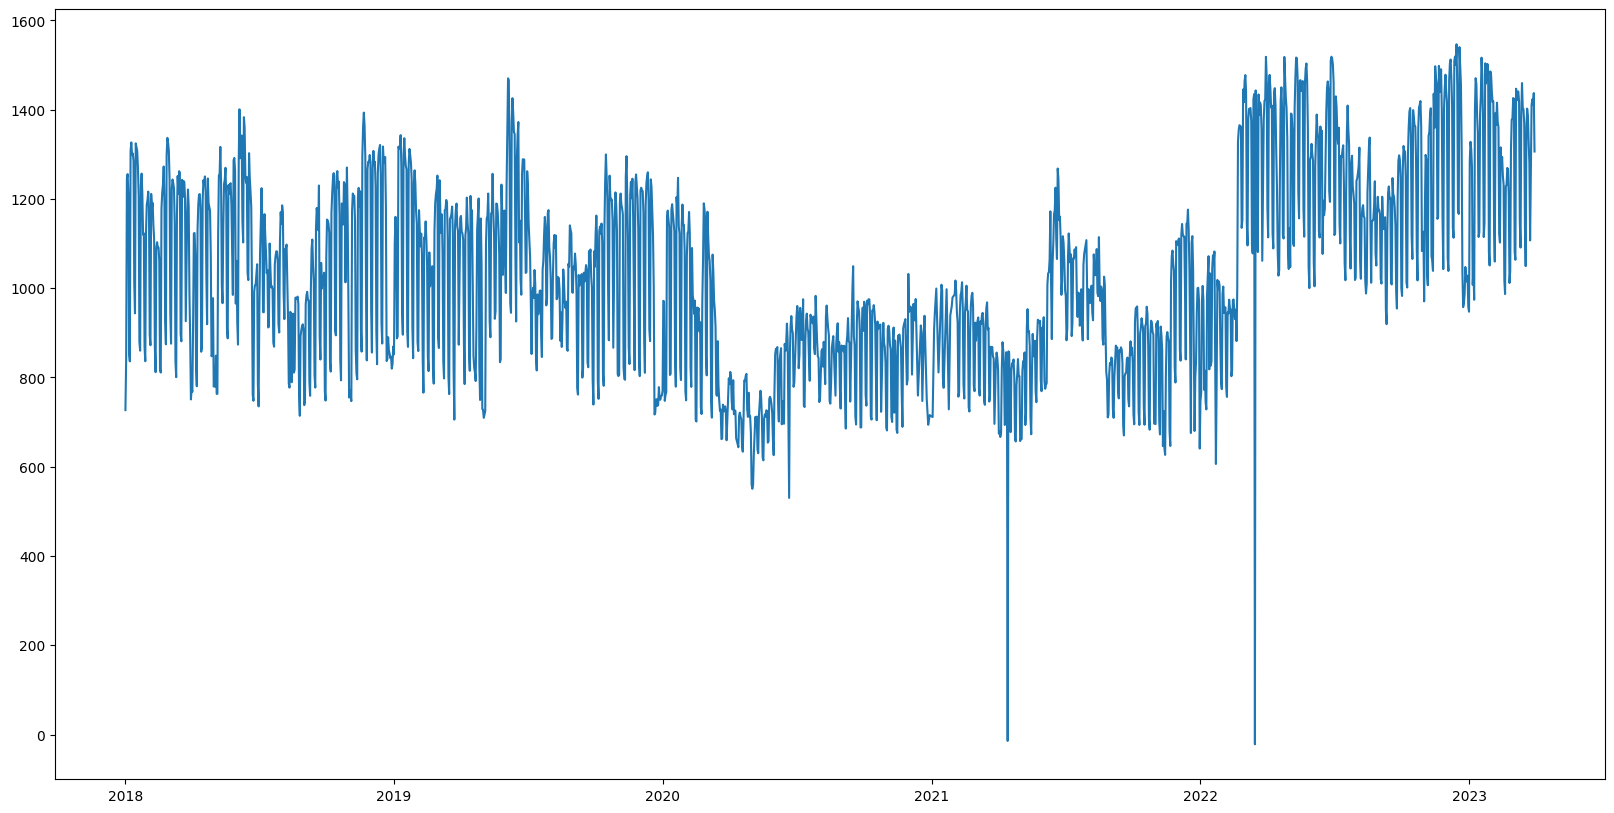

In [5]:
dummy = data['Consumption'].copy()

plt.figure(figsize=(20,10))
plt.plot(data.index,data['Consumption'])
#plt.plot(data.index,)

#### EDA

##### Korelacja między 'Consumption' a danymi pogodowymi

In [6]:
# calculate percentage change
data['Consumption_Ret'] = data['Consumption'].pct_change()
data['temperature_2m_Ret'] = data['temperature_2m'].pct_change()
data['relativehumidity_2m_Ret'] = data['relativehumidity_2m'].pct_change()
data['surface_pressure_Ret'] = data['surface_pressure'].pct_change()

In [7]:
prc_rate = ['temperature_2m_Ret','relativehumidity_2m_Ret','surface_pressure_Ret']

for key in prc_rate:
  corr = data['Consumption_Ret'].corr(data[key])
  print(f"Korelacja procentowa między Consumption and {key}:",corr)

Korelacja procentowa między Consumption and temperature_2m_Ret: -0.0019153572142670248
Korelacja procentowa między Consumption and relativehumidity_2m_Ret: -0.014640808721242743
Korelacja procentowa między Consumption and surface_pressure_Ret: -0.018995550103554738


##### Korelacja między 'ifWeekend' a consumption

In [8]:
le = preprocessing.LabelEncoder()
data['Consumption'] = le.fit_transform(data['Consumption'])
data['ifWeekend']= le.fit_transform(data['ifWeekend'])

In [9]:
stat = stats.pointbiserialr(data['ifWeekend'], data['Consumption'])
print(stat.statistic)

-0.4876689418186061


<ipython-input-9-d4874f084801>:1: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  stat = stats.pointbiserialr(data['ifWeekend'], data['Consumption'])


##### Zużycie prądu a miesiące

In [10]:
heatingMonths = [10, 11, 12, 1, 2, 3]

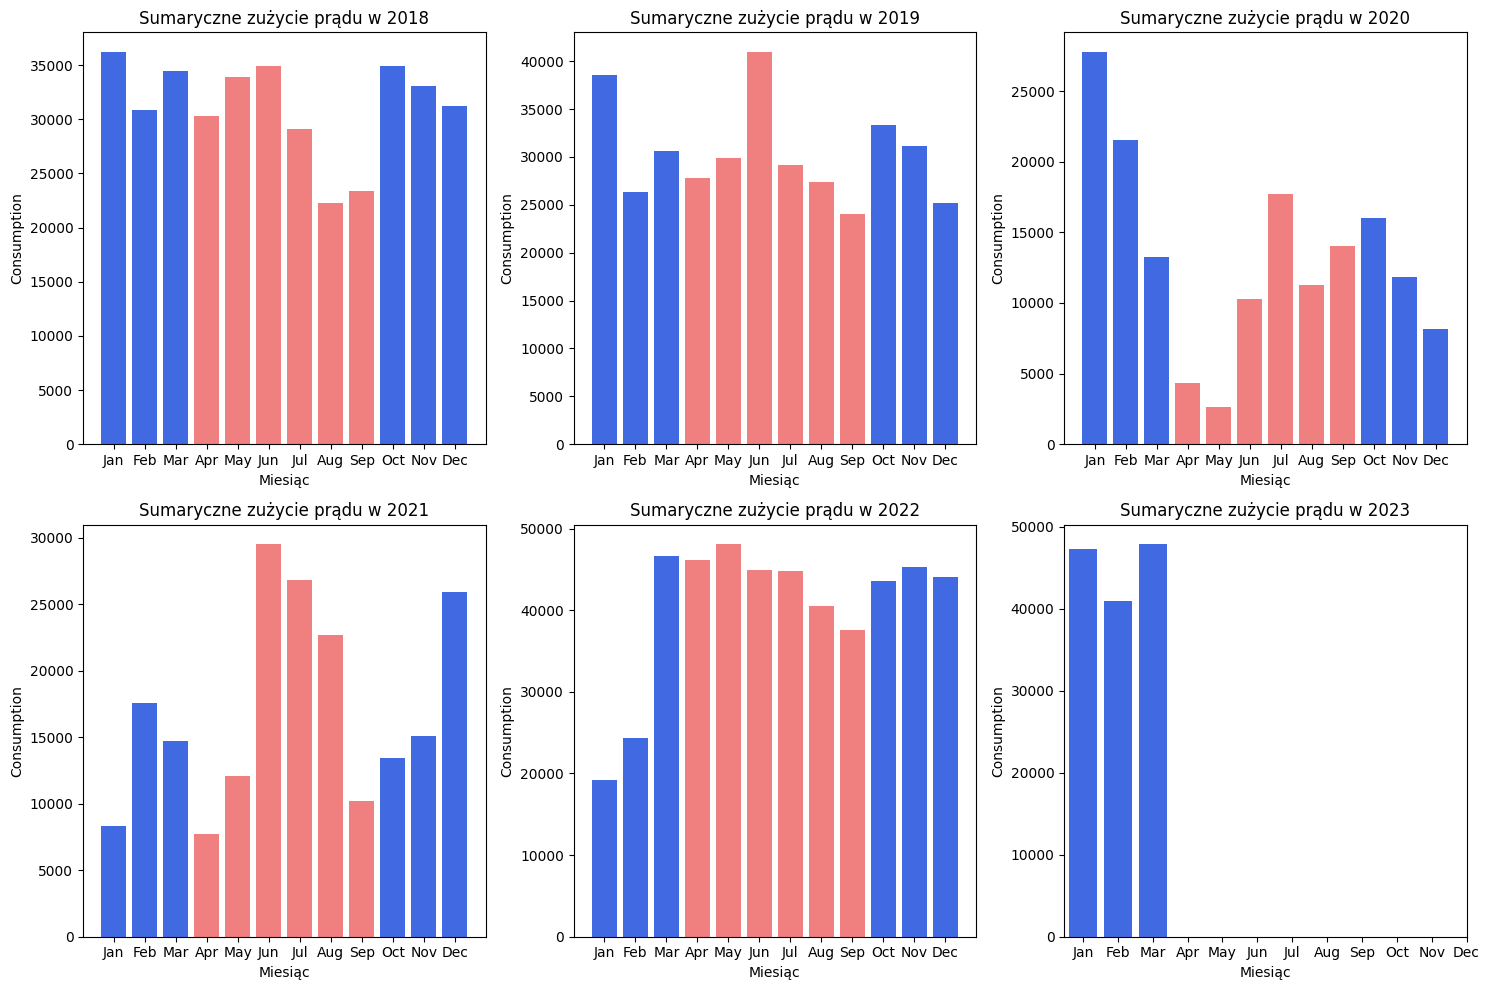

In [11]:
data['date'] = data.index
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

y = 2018
data_yearly = []
for i in range(6):
  data_yearly.append(data.query(f"year == {y}"))
  y += 1


plt.figure(figsize=(15,10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    monthly_consumption = data_yearly[i].groupby(['month'])['Consumption'].sum().reset_index()

    # Kolorowanie słupków dla miesięcy w sezonie grzewczym
    colors = ['royalblue' if month in heatingMonths else 'lightcoral' for month in monthly_consumption['month']]

    plt.bar(monthly_consumption['month'], monthly_consumption['Consumption'], color=colors)
    plt.title(f'Sumaryczne zużycie prądu w {2018 + i}')
    plt.xlabel('Miesiąc')
    plt.ylabel('Consumption')
    plt.xticks(range(1, 13),
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

##### Trendy

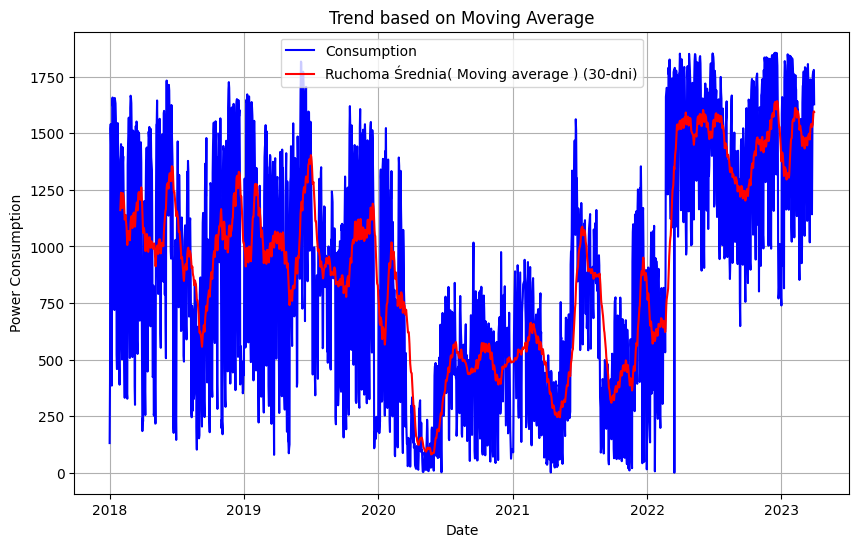

In [12]:
dt = data.copy()
dt['date'] = pd.to_datetime(dt.index)

dt.sort_values(by='date', inplace=True)

dt['moving_average'] = dt['Consumption'].rolling(window=30).mean()

plt.figure(figsize=(10, 6))
plt.plot(dt['date'], dt['Consumption'], label='Consumption', color='blue')
plt.plot(dt['date'], dt['moving_average'], label='Ruchoma Średnia( Moving average ) (30-dni)', color='red')
plt.title('Trend based on Moving Average')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

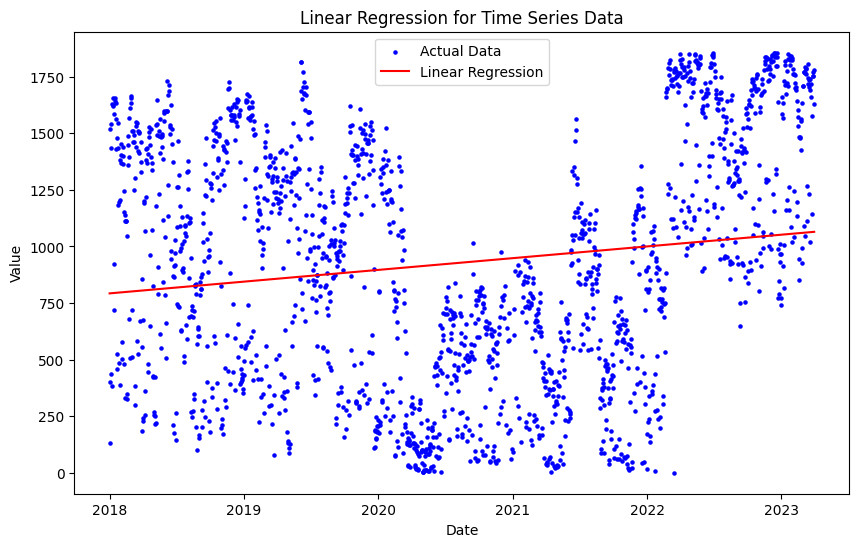

In [13]:
data_ordinal = data.copy()
data_ordinal['dateOrdinal'] = data['date'].apply(lambda x: x.toordinal())

X = data_ordinal[['dateOrdinal']]
y = data['Consumption']

model = LinearRegression()
model.fit(X, y)

y_pred_ = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(data['date'], data['Consumption'], color='blue', label='Actual Data',s=5)
plt.plot(data['date'], y_pred_, color='red', label='Linear Regression')
plt.title('Linear Regression for Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

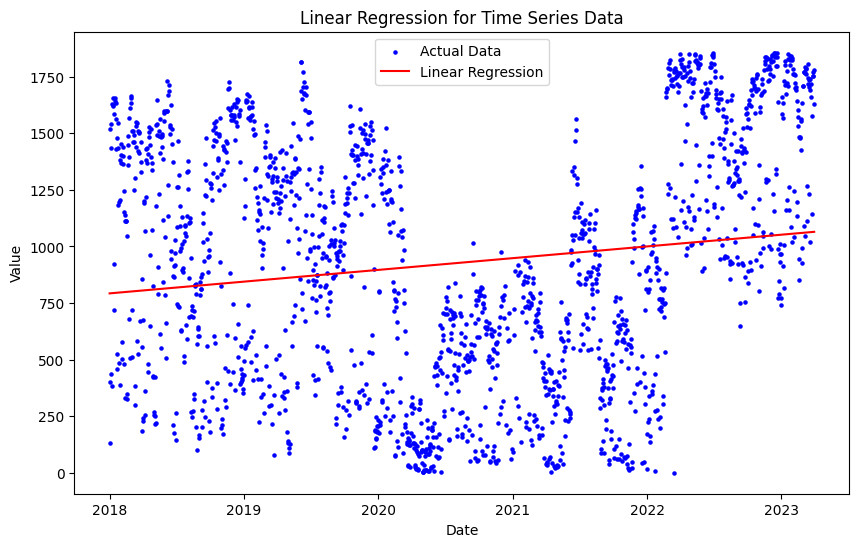

In [14]:
data_ordinal = data.copy()
data_ordinal['dateOrdinal'] = data['date'].apply(lambda x: x.toordinal())

X = data_ordinal[['dateOrdinal']]
y = data['Consumption']

model = LinearRegression()
model.fit(X, y)

y_pred_ = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(data['date'], data['Consumption'], color='blue', label='Actual Data',s=5)
plt.plot(data['date'], y_pred_, color='red', label='Linear Regression')
plt.title('Linear Regression for Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

##### Korelacja między 'heatingMonth' a consumption

In [15]:
heatingMonths = [10, 11, 12, 1, 2, 3]
data_heating = data.copy()
data_heating['heatingMonth'] = data['month'].isin(heatingMonths).astype(int)

In [16]:
le = preprocessing.LabelEncoder()
data_heating['heatingMonth'] = le.fit_transform(data_heating['heatingMonth'])
data_heating['Consumption']= le.fit_transform(data_heating['Consumption'])

In [17]:
stat = stats.pointbiserialr(data_heating['heatingMonth'], data_heating['Consumption'])
print(stat.statistic)

0.10946256602355124


<ipython-input-17-a9051e4f004f>:1: DeprecationWarning: Please import `pointbiserialr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  stat = stats.pointbiserialr(data_heating['heatingMonth'], data_heating['Consumption'])


#### Preprocessing


In [18]:
def date_to_datetime(s):
  return datetime.datetime(year=s.year, month=s.month, day=s.day)

In [19]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [21]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=7):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    #print(target_date)
    df_subset = dataframe.loc[:target_date].tail(n+1)
    #print(df_subset)
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Consumption'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

df = data.copy()
df['date'] = df['date'].apply(date_to_datetime)
df.set_index('date', inplace=True)
windowed_df = df_to_windowed_df(pd.DataFrame(df['Consumption']),
                                '2018-01-08',
                                '2023-03-23',
                                n=7)
windowed_df.shape

(1843, 9)

In [22]:
df = df.asfreq('D')

In [24]:
print(df.index.min(), df.index.max())
print(df.index.freq)  # powinno być 'D' dla danych dziennych

2018-01-01 00:00:00 2023-03-31 00:00:00
<Day>


In [25]:
# nowy kod
def create_dataset(data, history_size=10, future_size=10):
    X = []
    y = []
    end_ix = len(data) - future_size
    for start_ix in range(end_ix):
        end_history_ix = start_ix + history_size
        if end_history_ix + future_size > len(data):
            break
        X.append(data[start_ix:end_history_ix])
        y.append(data[end_history_ix:end_history_ix + future_size])
    return np.array(X), np.array(y)

X, y = create_dataset(pd.DataFrame(df['Consumption']))

In [26]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1843,), (1843, 7, 1), (1843,))

In [27]:
# nowy kod
# Zakładamy, że X i y są już przygotowane jako dane sekwencyjne
data_size = len(X)

# Określenie rozmiaru danych treningowych, walidacyjnych i testowych
train_size = int(data_size * 0.7)
val_size = int(data_size * 0.2)
test_size = data_size - train_size - val_size

# Podział danych na treningowe, walidacyjne i testowe
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Sprawdzenie rozmiarów podzielonych danych
print(f"Rozmiar danych treningowych: {len(X_train)}")
print(f"Rozmiar danych walidacyjnych: {len(X_val)}")
print(f"Rozmiar danych testowych: {len(X_test)}")
X_train.shape, y_train.shape,

Rozmiar danych treningowych: 1290
Rozmiar danych walidacyjnych: 368
Rozmiar danych testowych: 185


((1290, 7, 1), (1290,))

In [ ]:
# q_80 = int(len(dates) * .85)
# q_90 = int(len(dates) * .95)

# dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

# dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
# dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# plt.figure(figsize=(15,10))
# plt.plot(dates_train, y_train)
# plt.plot(dates_val, y_val)
# plt.plot(dates_test, y_test)

# plt.tight_layout()
# plt.legend(['Train', 'Validation', 'Test'])

#### Model Building

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Dopasowanie input_shape do Twoich danych (7 kroków czasowych, 1 cecha)
model = Sequential([
    layers.Input((7, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Wyjście to pojedyncza wartość (taka jak y_train)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 905377.7500 - mean_absolute_error: 820.0125 - val_loss: 1465119.0000 - val_mean_absolute_error: 1076.6299
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 888677.0000 - mean_absolute_error: 805.7780 - val_loss: 1431166.5000 - val_mean_absolute_error: 1060.7156
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 828901.7500 - mean_absolute_error: 772.0358 - val_loss: 1221485.3750 - val_mean_absolute_error: 965.1561
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 613126.6875 - mean_absolute_error: 629.4186 - val_loss: 794022.0625 - val_mean_absolute_error: 759.4630
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 362722.5000 - mean_absolute_error: 488.8301 - val_loss: 455947.1250 - val_mean_absolute_error: 571.0297
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 214078.3125 - mean_absolute_error: 383.1919 - val_loss: 281994.7500 - val_mean_absolute_error: 440.9576
Epoch 7/100
41/4

In [30]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 72670.2656 - mean_absolute_error: 200.0002 
Test MAE: 211.44178771972656
